In [45]:
%load_ext autoreload
%autoreload 1
%aimport twitterClient
%aimport TwitterProcessing

import sys
import json
import string
from collections import Counter
import nltk
import re
from tweepy import Cursor
import pandas as pd
import codecs
import numpy as np
import math

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from colorama import Fore, Back, Style
import matplotlib.pyplot as plt

from tweepy import api
from twitterClient import twitterClient
import pyLDAvis.sklearn
from wordcloud import WordCloud

from argparse import ArgumentParser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Vishwa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#Load tweets and save in json file

client = twitterClient.twitterClient()
file_name = "namotweets.json"
user_name = 'narendramodi'

f = open(file_name,"w")
tweetCount=0

# client.user_timeline, screen_name =user_name, lang = 'en'

for tweet in Cursor(client.search, q='#narendramodi', lang='en').items(2000):
    if tweet.lang == 'en':
        json.dump(tweet._json, f)
        f.write("\n")
        tweetCount += 1
        if tweetCount == 1:
            print(tweet)

#Display how many tweets we have collected
print("Downloaded {0} tweets".format(tweetCount))

f.close()

# tweet_json.to_json("tweets.json")

Status(_api=<tweepy.api.API object at 0x000001EACB7BEF60>, _json={'created_at': 'Sat Aug 31 02:59:47 +0000 2019', 'id': 1167633048835256321, 'id_str': '1167633048835256321', 'text': 'Economic buoyancy means Growth happens on its own\n\neconomic slow down  means You have to work harder to make growth… https://t.co/K3LIvRMDfS', 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/K3LIvRMDfS', 'expanded_url': 'https://twitter.com/i/web/status/1167633048835256321', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}, 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 954690936, 'id_str': '954690936', 'name': 'Guru makam', 'scree

In [28]:
# preprocessing tweets

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def processTweet(text):
    """
    Perform tokenisation, normalisation (lower case and stemming) and stopword and twitter keyword removal.

    @param text: tweet text
    @param tokenizer: tokeniser used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
        """
    
    # tweet tokeniser to use
    tokenizer = nltk.tokenize.TweetTokenizer()
    # we use the popular Porter stemmer
    stemmer = nltk.stem.PorterStemmer()
    # use the punctuation symbols defined in string.punctuation
    lPunct = list(string.punctuation)
    # use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
    stopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '’', '#narendramodi','@narendramodi']  # Use regular expressions to remove ..

    # covert all to lower case
    text = text.lower()
    # tokenise
    lTokens = tokenizer.tokenize(text)

    # strip whitespaces before and after
    lTokens = [token.strip() for token in lTokens]
    
    # stem (we use set to remove duplicates)
    lStemmedTokens = set([stemmer.stem(tok) for tok in lTokens])

    # pattern for digits
    # the list comprehension in return statement essentially remove all strings of digits or fractions, e.g., 6.15
    regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")
   
    # regex pattern for http
    regexHttp = re.compile("^http")
    regexHandles = re.compile("^@")
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    #words = set(nltk.corpus.words.words())
#and emoji_pattern.match(tok) == None and (tok in words or tok.isalpha())
    # remove stopwords, digits
    return [tok for tok in lStemmedTokens if tok not in stopwords and not tok.isdigit() and regexDigit.match(tok) == None and regexHttp.match(tok) == None and emoji_pattern.match(tok) == None and regexHandles.match(tok) == None]

In [ ]:
# basic stats

nltk.download('stopwords')

# number of most frequent terms to display
freqNum = 80

lTweets = []

# our term frequency counter
termFreqCounter = Counter()

# open json file and process it tweet by tweet
with open(file_name, 'r') as f:
    for line in f:
        tweet = json.loads(line)
        tweetText = tweet.get('text', '')
        # tokenise, filter stopwords and get convert to lower case
        lTokens = processTweet(text=tweetText)
        lTweets.append(' '.join(lTokens))
        # update count
        termFreqCounter.update(lTokens)

# print out most common terms
for term, count in termFreqCounter.most_common(freqNum):
    print(term + ': ' + str(count))

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')

plt.show()

In [22]:
def getHashtags(tweet):
    """
    Extracts the associatejd hashtags of tweet.

    @param tweet: The tweet, which is in the tweepy json format, and which we wish to extract its associated hashtags.

    @returns: list of hashtags (in lower case)
    """
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])

    return [tag['text'].lower() for tag in hashtags]

In [ ]:
# number of tweets to display
tweetThres = 50
tweets = []
# open file and use Counter to count the number of times the hash tags appears
with open(file_name, 'r') as f:
    hashtagsCounter = Counter()
    # for each line in file (which corresponds to a tweet), load it, get the hashtags and insert them into the
    # Counter
    for line in f:
        tweet = json.loads(line)
        hashtagsInTweet = getHashtags(tweet)
        hashtagsCounter.update(hashtagsInTweet)

    for tag, count in hashtagsCounter.most_common(tweetThres):
        print(tag + ": " + str(count))

In [40]:
# Sentiment analysis 

def vaderSentimentAnalysis(sTweetsFilename, bPrint):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param sTweetsFilename: name of input file containing a json formated tweet dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """

    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()


    lSentiment = []
    # open file and process tweets, one by one
    with open(sTweetsFilename, 'r') as f:
        for line in f:
            # each line is loaded according to json format, into tweet, which is actually a dictionary
            tweet = json.loads(line)

            try:
                tweetText = tweet.get('text', '')
                tweetDate = tweet.get('created_at')
                # pre-process the tweet text
                lTokens = processTweet(tweetText)

                # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
                # see lab sheet for what dSentimentScores holds
                dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))
                #dSentimentScores = sentAnalyser.polarity_scores(tweetText)

                # save the date and sentiment of each tweet (used for time series)
                lSentiment.append([pd.to_datetime(tweetDate), dSentimentScores['compound']])

                # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
                # of positive and negative words, we cannot use colorama to label each token
                if bPrint:
                    print(*lTokens, sep=', ')
                    #print(tweetText)
                    for cat,score in dSentimentScores.items():
                        print('{0}: {1}, '.format(cat, score), end='')
                    print()

            except KeyError as e:
                pass


    return lSentiment

In [31]:
# arguments for this notebook
# modify as needed if you want to do similar analaysis for other purposes

# input file of set of postive words
posWordFile = 'positive-words.txt'
# input file of set of negative words
negWordFile = 'negative-words.txt'
# input file of set of tweets (json format)
tweetsFile = 'namotweets.json'
# flag to determine whether to print out tweets and their sentiment
flagPrint = True
# specify the approach to take, one of [count, vader]
# change this to use a different sentiment approach
approach = 'vader'

In [34]:
"""
This is the main part of the notebook, that will can and run the various methods defined before.
"""

# construct the tweet pro-processing object
tweetTokenizer = TweetTokenizer()
lPunct = list(string.punctuation)
# standard 'English' stopwords plus we want to remove things like 'rt' (retweet) etc
lStopwords = stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`']

# call the TwitterProcessing python script
tweetProcessor = TwitterProcessing.TwitterProcessing(tweetTokenizer, lStopwords)


# load set of positive words
lPosWords = []
with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)


# load set of negative words
lNegWords = []
with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

NameError: name 'TweetTokenizer' is not defined

In [ ]:
# compute the sentiment
lSentiment = []
if approach == 'count':
    lSentiment = countWordSentimentAnalysis(setPosWords, setNegWords, tweetsFile, flagPrint)
elif approach == 'vader':
    lSentiment = vaderSentimentAnalysis(tweetsFile, flagPrint)

C:\Users\Vishwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
C:\Users\Vishwa\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


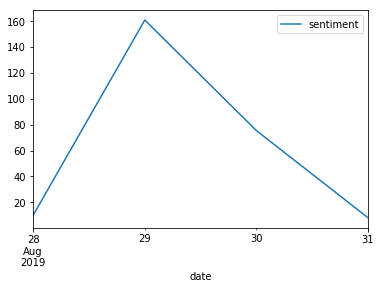

In [42]:
#
# TODO: timeseries part
#

# determine if we should output a time series of sentiment scores across time
# TODO: write code to display the time series (delete 'pass' below when you do)

# we are using pandas for this, but first we need to get it into a pandas data frame structure
series = pd.DataFrame(lSentiment, columns=['date', 'sentiment'])
# tell pandas that the date column is the one we use for indexing (or x-axis)
series.set_index('date', inplace=True)
# pandas makes a guess at the type of the columns, but to make sure it doesn't get it wrong, we set the sentiment
# column to floats
series[['sentiment']] = series[['sentiment']].apply(pd.to_numeric)

# This step is not necessary, but pandas has a neat function that allows us to group the series at different
# resultion.  The 'how=' part tells it how to group the instances.  In this example, it sames we want to group
# by day, and add up all the sentiment scores for the same day and create a new time series called 'newSeries'
# with this day resolution
# TODO: play with this for different resolution, '1H' is by hour, '1M' is by minute etc
newSeries = series.resample('1D', how='sum')
# this plots and shows the time series
newSeries.plot()
plt.show()

In [47]:
#
# LDA parameters
#

# number of topics to discover (default = 10)
topicNum = 10
# maximum number of words to display per topic (default = 10)
# Answer to Exercise 1 (change from 10 to 15)
wordNumToDisplay = 15
# this is the number of features/words to used to describe our documents
# please feel free to change to see effect
featureNum = 1500

In [48]:
"""
Performs counting via CountVectorizer and then apply the LDA model.
"""

#
# Count Vectorizer
#

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lTweets)
# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names()


#
# LDA MODEL
#

# Run LDA (see documentation about what the arguments means)
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [50]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [51]:
#
# Diplays discovered topics
#

display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

In [53]:
#
# pyLDAvis
#

# TODO: Add the pyLDAvis code here
# note if you also implemented the word cloud, that will display first, then once you close that
# file, then this will display
# Answer to exercise 2
panel = pyLDAvis.sklearn.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

C:\Users\Vishwa\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [54]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """

    # this normalises each row/topic to sum to one
    # use this normalisedComponents to display your wordclouds
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

    # TODO: complete the implementation
    
    #
    # Answer to Exercises 3 and 4
    #
    
    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 3
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)

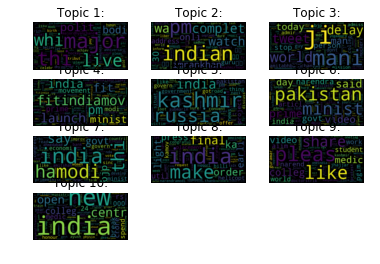

In [55]:
#
# Word Cloud
#

# display wordcloud
# TODO: go to the function definition and complete its implementation
displayWordcloud(ldaModel, tfFeatureNames)